# My first Chatbot with Langgraph

In [1]:
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

api_key = os.getenv("GroqAPI")
llm = ChatGroq(model="llama-3.3-70b-versatile", api_key=api_key)

In [5]:
#node functionality
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [6]:
graph_builder=StateGraph(State)
## its a chatbot node 
graph_builder.add_node("Myllm Chatbot",chatbot)
## these are the edges start and end

graph_builder.add_edge(START, "Myllm Chatbot")
graph_builder.add_edge("Myllm Chatbot", END)

## compile the graph
graph=graph_builder.compile()
graph_builder=StateGraph(State)

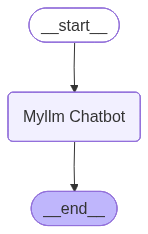

In [7]:
##visualize the Graph

from IPython.display import Image,display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [8]:
response=graph.invoke({"messages":"Hi"})

In [9]:
response["messages"][-1].content

"It's nice to meet you. Is there something I can help you with, or would you like to chat?"

In [10]:
for event in graph.stream({"messages":"Hi How are you"}):
    for value in event.values():
        print(value['messages'][-1].content)

I'm doing well, thanks for asking. I'm a large language model, so I don't have feelings or emotions like humans do, but I'm always happy to chat and help with any questions or topics you'd like to discuss. How about you? How's your day going so far?


# Use tools in Langgraph

In [11]:
from langchain_tavily import TavilySearch
tool = TavilySearch(tavily_api_key=os.getenv("TAVILY_API_KEY"), max_results=2)
tool.invoke("what is langgraph")


{'query': 'what is langgraph',
 'response_time': 0.53,
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://huggingface.co/learn/agents-course/en/unit2/langgraph/when_to_use_langgraph',
   'title': 'What is LangGraph ? - Hugging Face Agents Course',
   'content': '# What is LangGraph ? `LangGraph` is a framework developed by LangChain **to manage the control flow of applications that integrate an LLM**. ## When should I use LangGraph ? `LangGraph` is on the other end of the spectrum, it shines when you need **“Control”** on the execution of your agent. LangGraph is particularly valuable when you need **Control over your applications**. It gives you the tools to build an application that follows a predictable process while still leveraging the power of LLMs. Put simply, if your application involves a series of steps that need to be orchestrated in a specific way, with decisions being made at each junction point, **LangGraph provides the structure y

In [12]:
def multiply(a:int,b:int)->int:
    """mutiply a and b
    
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [13]:
tools=[tool,multiply]

In [14]:
llm_with_tools=llm.bind_tools(tools)

In [15]:
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001F4FC43D4F0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001F4FB0BF4A0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input

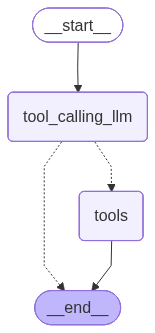

In [16]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Graph 
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## build edegs
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools",END)

graph=builder.compile()

from IPython.display import Image,display   
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
response=graph.invoke({"messages":"what is the recent ai news"})

In [18]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://patmcguinness.substack.com/p/ai-week-in-review-260207", "title": "AI Week in Review 26.02.07 - Substack", "score": 0.7663815, "published_date": "Sat, 07 Feb 2026 23:53:11 GMT", "content": "On the same day this week, Anthropic and OpenAI launched competing frontier AI models – Opus 4.6 and GPT-5.3-Codex – that are both the new state-of-the-art in agentic AI. **OpenAI released GPT-5.3-Codex**, an agentic AI model designed to generate, debug, and reason over complex codebases across long-horizon tasks. **Kling AI released Kling 3.0**, an all-in-one multimodal video generation model supporting text, image, audio, and multi-shot video creation. Expanding their terminal-based Codex AI code tool into an app, **OpenAI released a native Codex application for macOS.** The app provides a dedicated desktop GUI interface for managing AI coding workflows, with voice dictation, slash c

In [19]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (y7jy1a6xj)
 Call ID: y7jy1a6xj
  Args:
    query: recent AI news
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://patmcguinness.substack.com/p/ai-week-in-review-260207", "title": "AI Week in Review 26.02.07 - Substack", "score": 0.7663815, "published_date": "Sat, 07 Feb 2026 23:53:11 GMT", "content": "On the same day this week, Anthropic and OpenAI launched competing frontier AI models – Opus 4.6 and GPT-5.3-Codex – that are both the new state-of-the-art in agentic AI. **OpenAI released GPT-5.3-Codex**, an agentic AI model designed to generate, debug, and reason over co

In [20]:
response=graph.invoke({"messages":"what is 2 multipy 3 is"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2 multipy 3 is
================================== Ai Message ==================================
Tool Calls:
  multiply (5j69eyrnk)
 Call ID: 5j69eyrnk
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


# React Agent 

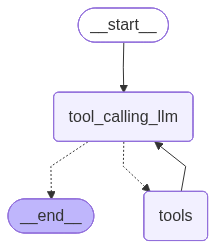

In [21]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Graph 
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## build edegs
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")

graph=builder.compile()

from IPython.display import Image,display   
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
response=graph.invoke({"messages":"tell me ai news and what is 2 multipy 3 is"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

tell me ai news and what is 2 multipy 3 is
================================== Ai Message ==================================
Tool Calls:
  tavily_search (7wrngc1vg)
 Call ID: 7wrngc1vg
  Args:
    query: AI news
    topic: general
  multiply (0w22j87aq)
 Call ID: 0w22j87aq
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news", "response_time": 1.35, "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.artificialintelligence-news.com/", "title": "AI News | Latest News | Insights Powering AI-Driven Business Growth", "content": "AI Business Strategy, AI in Action, Artificial Intelligence, Featured News, Features. AI Business Strategy, AI in Action, Artificial Intelligence, Featured News, Inside AI. AI Business Strategy, AI in Action, Artificial Intelligence, Featured News, Featu

In [23]:
response=graph.invoke({"messages":"my name is kartikey buddy tell me somthing"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

my name is kartikey buddy tell me somthing
================================== Ai Message ==================================

Hello Kartikey, it's nice to meet you, buddy. I'd be happy to chat with you and share some interesting information. Would you like to talk about a specific topic, or would you like me to suggest something?


In [24]:
response=graph.invoke({"messages":"whats my name llm"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

whats my name llm
================================== Ai Message ==================================

I don't have any information about your name. I'm a large language model, I don't have personal interactions or store information about individuals. Each time you interact with me, it's a new conversation. If you'd like to share your name or any other information, I'm here to chat!


# Add the memory in my Chatbot

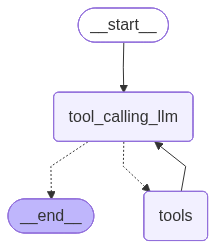

In [29]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver    

memory=MemorySaver()

## Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Graph 
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## build edegs
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")

graph=builder.compile(checkpointer=memory)

from IPython.display import Image,display   
display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
config={"configurable":{"thread_id": "1"}}
response=graph.invoke({"messages":"My name is kartikey"}, config=config)
response

{'messages': [HumanMessage(content='My name is kartikey', additional_kwargs={}, response_metadata={}, id='404bff9f-e4d5-4dee-9551-0ad6db882ee2'),
  AIMessage(content="Hello Kartikey, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 1755, 'total_tokens': 1783, 'completion_time': 0.084048482, 'completion_tokens_details': None, 'prompt_time': 0.106739428, 'prompt_tokens_details': None, 'queue_time': 0.049093532, 'total_time': 0.19078791}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c3e5e-6af6-7342-864d-7c6ab600cef0-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1755, 'output_tokens': 28, 'total_tokens': 1783})]}

In [31]:
response['messages'][-1].content

"Hello Kartikey, it's nice to meet you. Is there something I can help you with or would you like to chat?"

In [34]:
response=graph.invoke({"messages":"hey do you remeber my name"}, config=config)
response['messages'][-1].content

'Yes, I remember your name. You told me earlier that your name is Kartikey.'

# Streaming

In [35]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [36]:
def superbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

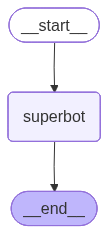

In [37]:
graph=StateGraph(State)

graph.add_node("superbot", superbot)
graph.add_edge(START, "superbot")
graph.add_edge("superbot", END)

graph_builder=graph.compile(checkpointer=memory)

from IPython.display import Image,display
display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [39]:
config={"configurable":{"thread_id": "1"}}
graph_builder.invoke({"messages":"hii my name is kartikey and i love to create chatbot"}, config=config)

{'messages': [HumanMessage(content='hii my name is kartikey and i love to create chatbot', additional_kwargs={}, response_metadata={}, id='38adfeee-5588-44da-817f-9e299809ecb3'),
  AIMessage(content="Hello Kartikey! Nice to meet you! It's great to hear that you're interested in creating chatbots! That's a fascinating field, and there are many exciting possibilities with conversational AI.\n\nWhat kind of chatbots are you interested in creating? Are you looking to build simple text-based bots or more advanced voice-enabled assistants? Do you have a specific platform or programming language in mind, such as Python, JavaScript, or Dialogflow?\n\nI'm here to help and chat with you about chatbots, so feel free to share your ideas and ask any questions you may have!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 119, 'prompt_tokens': 50, 'total_tokens': 169, 'completion_time': 0.368957577, 'completion_tokens_details': None, 'prompt_time': 0.002235212, 'prompt

# I use the update stream mode which is give the AI messages 

In [40]:
config={"configurable":{"thread_id": "1"}}
for chunk in graph_builder.stream({"messages":"hii my name is kartikey and i love to create chatbot"}, config=config,stream_mode='updates'):
    print(chunk)

{'superbot': {'messages': [AIMessage(content="Hello again Kartikey! Nice to see you again! It's great that you're passionate about creating chatbots. Chatbots are an amazing way to interact with users and provide them with helpful information and assistance.\n\nSo, what's your favorite thing about creating chatbots? Is it the coding, the design, or the possibility of helping people with your creations?\n\nAlso, have you built any chatbots yet? If so, what kind of chatbots have you built? Are they simple Q&A bots or more complex conversational bots?\n\nLet's chat more about chatbots and see if we can come up with some cool ideas for your next project!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 132, 'prompt_tokens': 193, 'total_tokens': 325, 'completion_time': 0.487561235, 'completion_tokens_details': None, 'prompt_time': 0.009443613, 'prompt_tokens_details': None, 'queue_time': 0.050181506, 'total_time': 0.497004848}, 'model_name': 'llama-3.3-70b-ver

# I use the value stream mode which is give the AI messages 

In [41]:
config={"configurable":{"thread_id": "1"}}
for chunk in graph_builder.stream({"messages":"hii my name is kartikey and i love to create chatbot"}, config=config,stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='hii my name is kartikey and i love to create chatbot', additional_kwargs={}, response_metadata={}, id='38adfeee-5588-44da-817f-9e299809ecb3'), AIMessage(content="Hello Kartikey! Nice to meet you! It's great to hear that you're interested in creating chatbots! That's a fascinating field, and there are many exciting possibilities with conversational AI.\n\nWhat kind of chatbots are you interested in creating? Are you looking to build simple text-based bots or more advanced voice-enabled assistants? Do you have a specific platform or programming language in mind, such as Python, JavaScript, or Dialogflow?\n\nI'm here to help and chat with you about chatbots, so feel free to share your ideas and ask any questions you may have!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 119, 'prompt_tokens': 50, 'total_tokens': 169, 'completion_time': 0.368957577, 'completion_tokens_details': None, 'prompt_time': 0.002235212, 'prompt_t

In [43]:
# look if i use it in streamming mode how its work
config={"configurable":{"thread_id": "2"}}
for chunk in graph_builder.stream({"messages":"hi i love coding"}, config=config,stream_mode='updates'):
    print(chunk)

{'superbot': {'messages': [AIMessage(content='Coding is an amazing skill to have, and it can be so much fun. What do you like to code about? Do you have a favorite project or a favorite programming language, such as Python, Java, or JavaScript?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 101, 'total_tokens': 147, 'completion_time': 0.182599545, 'completion_tokens_details': None, 'prompt_time': 0.004725727, 'prompt_tokens_details': None, 'queue_time': 0.049239171, 'total_time': 0.187325272}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c06d5113ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c3e79-5ca4-7f71-8411-a6427a05fbf8-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 101, 'output_tokens': 46, 'total_tokens': 147})]}}


In [44]:
config={"configurable":{"thread_id": "2"}}
for chunk in graph_builder.stream({"messages":"but i love singing also"}, config=config,stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='hi i love coding', additional_kwargs={}, response_metadata={}, id='9ce8a36a-ffcd-481c-8f01-ad0c7721f278'), AIMessage(content="That's awesome! Coding can be such a rewarding and creative outlet. What kind of coding do you enjoy doing? Are you into web development, mobile app development, game development, or something else? Do you have a favorite programming language?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 39, 'total_tokens': 88, 'completion_time': 0.109401976, 'completion_tokens_details': None, 'prompt_time': 0.003236384, 'prompt_tokens_details': None, 'queue_time': 0.048665043, 'total_time': 0.11263836}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c3e79-3133-7b53-8ce6-b7b54492b2b9-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'in

In [ ]:
# if i want to detailed information about the streaming we can use the astream_events
config={"configurable":{"thread_id": "3"}}
async def run():
   async for chunk in graph_builder.astream_events({"messages":["hii my name is kartikey and i love to create chatbot"]},config,version='v1'):
       print(chunk)
await run()